In [22]:
# STEP 1: IMPORT REQUIRED LIBRARIES
# Core
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.19.0


In [23]:
# STEP 2: MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# STEP 3: DATASET PATH SETUP
BASE_DIR = "/content/drive/MyDrive/Dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "Training")
TEST_DIR  = os.path.join(BASE_DIR, "Testing")

classes = sorted(os.listdir(TRAIN_DIR))

print("Classes Found:", classes)
print("Number of Classes:", len(classes))


Classes Found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of Classes: 4


In [ ]:
# STEP 4: IMAGE COUNT PER CLASS
data = []

for cls in classes:
    train_count = len(os.listdir(os.path.join(TRAIN_DIR, cls)))
    test_count  = len(os.listdir(os.path.join(TEST_DIR, cls)))
    data.append([cls, train_count, test_count])

df_counts = pd.DataFrame(
    data, columns=["Class", "Training Images", "Testing Images"]
)

df_counts


,Class,Training Images,Testing Images
0,glioma,1333,300
1,meningioma,1339,306
2,notumor,1599,405
3,pituitary,1457,300


In [ ]:
# STEP 5: PARAMETERS
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

In [ ]:
# STEP 6: DATA AUGMENTATION
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# STEP 7: DATA GENERATORS
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 4872 images belonging to 4 classes.
Found 856 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# STEP 8: HANDLE CLASS IMBALANCE
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict


{0: np.float64(1.0740740740740742),
 1: np.float64(1.0693590869183494),
 2: np.float64(0.8955882352941177),
 3: np.float64(0.9830508474576272)}

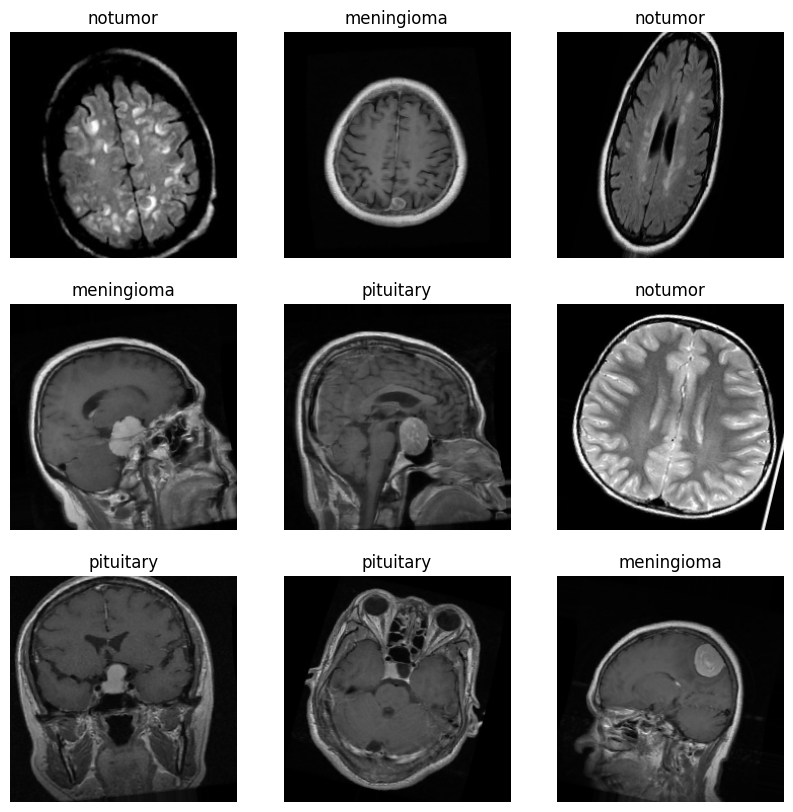

In [ ]:
# STEP 9: VISUALIZE SAMPLE IMAGES
images, labels = next(train_generator)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(classes[np.argmax(labels[i])])
plt.show()


In [ ]:
# STEP 10: BUILD INCEPTIONV3 MODEL
from tensorflow.keras.applications import InceptionV3

def build_inceptionv3(input_shape, num_classes):
    base_model = InceptionV3(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False  # Transfer Learning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model


In [ ]:
# STEP 11: COMPILE MODEL
inception_model = build_inceptionv3(
    input_shape=(224, 224, 3),
    num_classes=len(classes)
)

inception_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

inception_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,336,548 (85.21 MB)

 Trainable params: 529,668 (2.02 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [ ]:
# STEP 12: CALLBACKS
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3, verbose=1),
    ModelCheckpoint(
        "/content/drive/MyDrive/BrainTumorProject/inceptionv3_best.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )
]


In [ ]:
# STEP 13: TRAIN MODEL
history = inception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9319 - loss: 0.1981
Epoch 1: val_accuracy did not improve from 0.88668
153/153 ━━━━━━━━━━━━━━━━━━━━ 103s 666ms/step - accuracy: 0.9318 - loss: 0.1981 - val_accuracy: 0.8797 - val_loss: 0.3535 - learning_rate: 1.0000e-04
Epoch 2/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9290 - loss: 0.2022
Epoch 2: val_accuracy did not improve from 0.88668
153/153 ━━━━━━━━━━━━━━━━━━━━ 90s 591ms/step - accuracy: 0.9289 - loss: 0.2022 - val_accuracy: 0.8703 - val_loss: 0.3515 - learning_rate: 1.0000e-04
Epoch 3/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9328 - loss: 0.1958
Epoch 3: val_accuracy improved from 0.88668 to 0.89486, saving model to /content/drive/MyDrive/BrainTumorProject/inceptionv3_best.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 91s 592ms/step - accuracy: 0.9328 - loss: 0.1958 - val_accuracy: 0.8949 - val_loss: 0.3020 - learning_rate: 1.0000e-04
Epoch 4/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step

In [ ]:
# STEP 14: PRINT FINAL TRAINING & VALIDATION ACCURACY
final_train_acc = history.history['accuracy'][-1]
final_val_acc   = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy   : {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy : {final_val_acc*100:.2f}%")


Final Training Accuracy   : 93.80%
Final Validation Accuracy : 89.60%


In [ ]:
# STEP 15: TESTING ACCURACY
test_loss, test_accuracy = inception_model.evaluate(test_generator, verbose=0)

print(f"Test Accuracy : {test_accuracy*100:.2f}%")

Test Accuracy : 93.90%


In [ ]:
# STEP 16: PREDICTIONS ON TEST DATA
y_true = test_generator.classes

y_pred_probs = inception_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step


In [ ]:
# STEP 17: CLASSIFICATION REPORT (CLASS-WISE PERFORMANCE)
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=classes
))


Classification Report:

              precision    recall  f1-score   support

      glioma       0.92      0.90      0.91       300
  meningioma       0.88      0.89      0.88       306
     notumor       0.99      0.98      0.99       405
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.94      1311
   macro avg       0.93      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



In [ ]:
# STEP 18: CONFUSION MATRIX — NUMERIC (TABLE FORM)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

cm_df = pd.DataFrame(
    cm,
    index=classes,
    columns=classes
)

print("Numeric Confusion Matrix:")
display(cm_df)


Numeric Confusion Matrix:


,glioma,meningioma,notumor,pituitary
glioma,271,26,1,2
meningioma,18,271,2,15
notumor,4,4,396,1
pituitary,1,6,0,293


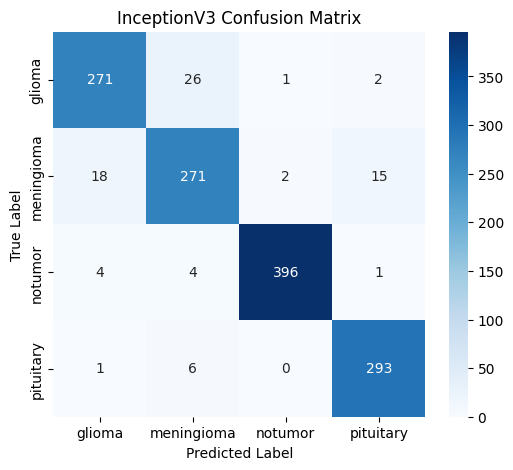

In [ ]:
# STEP 19: CONFUSION MATRIX — HEATMAP
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("InceptionV3 Confusion Matrix")
plt.show()


In [ ]:
# STEP 20: SAVE FINAL MODEL
MODEL_SAVE_PATH = "/content/drive/MyDrive/BrainTumorProject/inceptionv3_final.keras"

inception_model.save(MODEL_SAVE_PATH)

print("Model saved successfully at:")
print(MODEL_SAVE_PATH)


Model saved successfully at:
/content/drive/MyDrive/BrainTumorProject/inceptionv3_final.keras


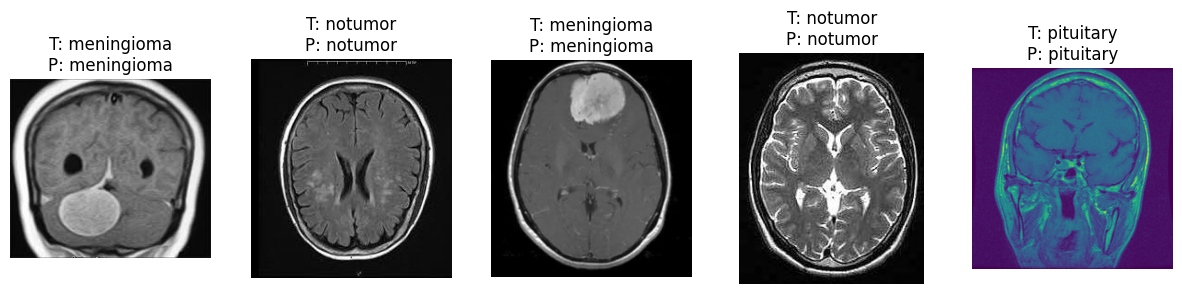

In [ ]:
# SAMPLE CORRECT & WRONG PREDICTIONS
import random

indices = random.sample(range(len(y_true)), 5)

plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)

    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"T: {classes[y_true[idx]]}\nP: {classes[y_pred[idx]]}"
    )
plt.show()


In [ ]:
# PER-CLASS ACCURACY
class_correct = np.diag(cm)
class_total = cm.sum(axis=1)

for i, cls in enumerate(classes):
    acc = class_correct[i] / class_total[i]
    print(f"{cls} Accuracy: {acc*100:.2f}%")

glioma Accuracy: 90.33%
meningioma Accuracy: 88.56%
notumor Accuracy: 97.78%
pituitary Accuracy: 97.67%


In [16]:
# STEP 21:IMPLEMENTATION OF GRAD-CAM
## IMPORT REQUIRED LIBRARIES
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [9]:
## LOAD THE MODEL
MODEL_PATH = "/content/drive/MyDrive/BrainTumorProject/inceptionv3_best.keras"

model = tf.keras.models.load_model(MODEL_PATH)
print("Final InceptionV3 model loaded successfully")


Final InceptionV3 model loaded successfully


In [17]:
## IDENTIFY THE LAST CONVOLUTION LAYER
LAST_CONV_LAYER = "mixed10"

In [25]:
## GRAD-CAM HEATMAP FUNCTION
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)

    return heatmap.numpy()


In [26]:
## OVERLAY HEATMAP ON MRI IMAGE
def display_gradcam(img_path, model, last_conv_layer, class_names):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict class
    preds = model.predict(img_array)
    pred_class = np.argmax(preds)
    confidence = preds[0][pred_class]

    # Generate heatmap
    heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer, pred_class
    )

    # Read original image (for overlay)
    orig_img = cv2.imread(img_path)
    orig_img = cv2.resize(orig_img, (224,224))

    heatmap = cv2.resize(heatmap, (224,224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

    # Display
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(
        f"Prediction: {class_names[pred_class]} "
        f"({confidence*100:.2f}%)"
    )
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


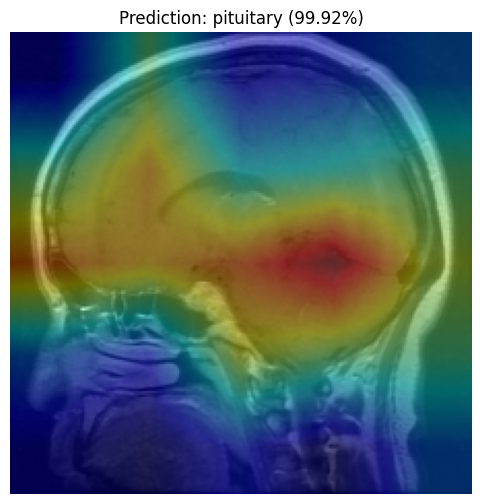

In [27]:
## TEST GRAD-CAM WITH A SAMPLE MRI IMAGE
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

sample_image_path = "/content/Te-piTr_0004.jpg"  # change path if needed

display_gradcam(
    sample_image_path,
    model,
    LAST_CONV_LAYER,
    classes
)


True Class: notumor
Image Path: /content/drive/MyDrive/Dataset/Testing/notumor/Te-no_0385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


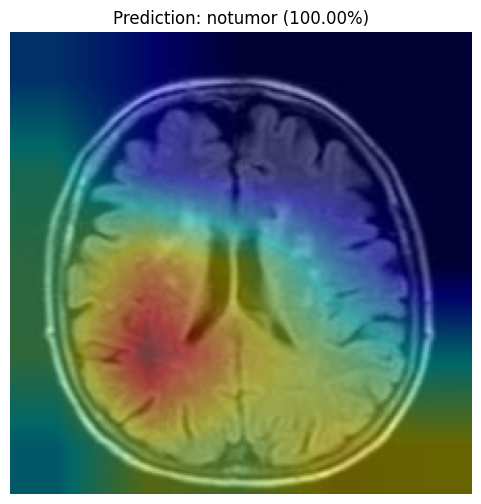

In [28]:
## RANDOM IMAGE FROM TEST SET
import random

def get_random_test_image(test_dir, classes):
    cls = random.choice(classes)
    cls_dir = os.path.join(test_dir, cls)
    img_name = random.choice(os.listdir(cls_dir))
    return os.path.join(cls_dir, img_name), cls


# Pick random image
random_img_path, true_class = get_random_test_image(TEST_DIR, classes)

print("True Class:", true_class)
print("Image Path:", random_img_path)

# Display Grad-CAM
display_gradcam(
    random_img_path,
    model,
    LAST_CONV_LAYER,
    classes
)
